In [1]:
from osgeo import ogr
from osgeo import gdal
import os, re
import json
import zipfile
import time
import numpy as np

# from shapely.geometry.polygon import LinearRing, Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

In [2]:
def open_shape(zippedfile="./HYS20120418.zip", decompressdir="./descomp"):
    zipf = zipfile.ZipFile(zippedfile)
    regexext = re.compile(".*\.shp$")
    nameshapes = list(filter(lambda x: regexext.match(x), zipf.namelist()))
    # print(nameshapes)
    os.makedirs(decompressdir, exist_ok=True)
    nameshapesp = list(map(lambda x: x.replace(".shp", ""), nameshapes))
    shapedict = dict()
    for shapef, shapename in zip(nameshapes, nameshapesp):
        zipf.extract(shapef, decompressdir)
        zipf.extract(shapef.replace(".shp", ".shx"), decompressdir)
        shapepath = os.path.join(decompressdir, shapef)
        # print(shapepath)
        shapefile = ogr.Open(shapepath)
        shapelayer = shapefile.GetLayer(0)
        nfeats = shapelayer.GetFeatureCount()
        coords = []
        values_f = []
        for i in range(nfeats):
            # first feature of the shapefile
            feature = shapelayer.GetFeature(i)
            jsonfeat = feature.ExportToJson()
            values = json.loads(jsonfeat)
            values_arr = values["geometry"]["coordinates"][0]
            values_f.append(values)
            # La primer capa es la mas grande, preguntar si se utilizaria
            coords.append(np.asarray(values_arr))
        shapedict.update({shapename: {"jsonShape": values_f,
                                      "coords": coords}})
    return shapedict

def graph_shape(coords):
    minx = np.min(list(map(lambda x: x[:, 0].min(), coords)))
    maxx = np.max(list(map(lambda x: x[:, 0].max(), coords)))
    miny = np.min(list(map(lambda x: x[:, 1].min(), coords)))
    maxy = np.max(list(map(lambda x: x[:, 1].max(), coords)))
    patches = []
    fig, ax = plt.subplots()
    for co in coords:
        polygon = Polygon(co, True)
        patches.append(polygon)
    p = PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)
    ax.add_collection(p)
    ax.set_xlim(minx - 1, maxx + 1)
    ax.set_ylim(miny - 1, maxy + 1)
    # fig.show()
    return fig, patches

def poligon2bitmap(polygon, size=(300, 300), offset=30):
    polyx = reubicar(polygon[:, 0], size[0] - offset, offset)
    polyy = reubicar(polygon[:, 1], size[1] - offset, offset)
    img = np.zeros((size[0], size[0], 3), dtype=np.uint8)
    points = np.hstack((polyx.reshape(-1, 1), polyy.reshape(-1, 1)))
    # cv2.fillPoly(img, pts=[points], color=(255, 0, 0))
    return points

def boundingBoxToOffsets(bbox, geot):
    col1 = int((bbox[0] - geot[0]) / geot[1])
    col2 = int((bbox[1] - geot[0]) / geot[1]) + 1
    row1 = int((bbox[3] - geot[3]) / geot[5])
    row2 = int((bbox[2] - geot[3]) / geot[5]) + 1
    return [row1, row2, col1, col2]

def geotFromOffsets(row_offset, col_offset, geot):
    new_geot = [geot[0] + (col_offset * geot[1]), \
        geot[1], 0.0, geot[3] + (row_offset * geot[5]), \
        0.0, geot[5]]
    return new_geot

(<Figure size 432x288 with 1 Axes>,
  <matplotlib.patches.Polygon at 0x7fca46cfea58>])

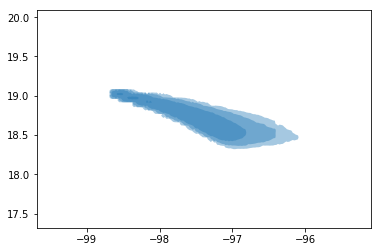

In [11]:
# Graficar Shape a partir de funciones basicas
shapedict = open_shape(zippedfile="./Data/HYS20120420.zip")
graph_shape(shapedict["GIS_06705_22178_06"]["coords"])

# Conversion de shape image a raster utilizando gdal

(-98.69017344043361, 0.004354034387426428, 0.0, 19.088171868918984, 0.0, -0.004354034387426428)


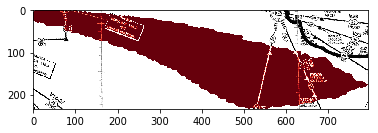

In [12]:
## Cargar imagen
imgtif = gdal.Open("../MAPA_AEROVIAS_GEORECTIFICADO2.tif", gdal.GA_ReadOnly)
# get geotransform and no data for raster
geot = imgtif.GetGeoTransform()
nodata = imgtif.GetRasterBand(1).GetNoDataValue()
zstats = []  # empty list to hold the zonal statistics once they are calculated
mem_driver = ogr.GetDriverByName("Memory")
mem_driver_gdal = gdal.GetDriverByName("MEM")
shp_name = "temp"
tp_ds = mem_driver.CreateDataSource(shp_name)
tp_lyr = tp_ds.CreateLayer('polygons', None, ogr.wkbPolygon)
fn_zones = "../HYS20120420/GIS_06705_22178_08.shp"
p_ds = ogr.Open(fn_zones)
lyr = p_ds.GetLayer()
p_feat = lyr.GetNextFeature()
tp_lyr.CreateFeature(p_feat.Clone())

offsets = boundingBoxToOffsets(p_feat.GetGeometryRef().GetEnvelope(),\
        geot)  # get the bounding box of the polygon feature and convert the coordinates to cell offsets
new_geot = geotFromOffsets(offsets[0], offsets[2], geot)  # calculate the new geotransform for the polygonized raster
tr_ds = mem_driver_gdal.Create("", \
        offsets[3] - offsets[2], \
        offsets[1] - offsets[0], \
        1, gdal.GDT_Byte)
tr_ds.SetGeoTransform(new_geot)
gdal.RasterizeLayer(tr_ds, [1], tp_lyr, burn_values=[1])
tr_array = tr_ds.ReadAsArray()
# read data from the input raster that corresponds
# to the location of the rasterized polygon
r_array = imgtif.GetRasterBand(1).ReadAsArray(\
offsets[2],\
offsets[0],\
offsets[3] - offsets[2],\
offsets[1] - offsets[0])

# get the ID of the polygon feature, you can use a different attribute field
id = p_feat.GetFID()

## Print simulation
if r_array is not None:
    ## Implica que la raster band se cargue y limitar
    maskarray = np.logical_or(r_array==nodata, tr_array)
print(tr_ds.GetGeoTransform())

va = np.ma.masked_array(r_array, maskarray)
vb = np.ma.masked_array(r_array, np.logical_not(maskarray))

cm = plt.imshow(va, cmap='gray')
plt.imshow(vb, cmap='Reds')
plt.show()

# Codigo para construir un raster a partir de un shape

```python
# get geotransform and no data for raster
geot = imgtif.GetGeoTransform()
nodata = imgtif.GetRasterBand(1).GetNoDataValue()
# empty list to hold the zonal statistics once they are calculated
zstats = []
mem_driver = ogr.GetDriverByName("Memory")
mem_driver_gdal = gdal.GetDriverByName("MEM")
shp_name = "temp"
tp_ds = mem_driver.CreateDataSource(shp_name)
tp_lyr = tp_ds.CreateLayer('polygons', None, ogr.wkbPolygon)
fn_zones = "../HYS20120420/GIS_06705_22178_08.shp"
p_ds = ogr.Open(fn_zones)
lyr = p_ds.GetLayer()
p_feat = lyr.GetNextFeature()
tp_lyr.CreateFeature(p_feat.Clone())
# get the bounding box of the polygon feature and convert the coordinates
# to cell offsets
offsets = boundingBoxToOffsets(p_feat.GetGeometryRef().GetEnvelope(),\
        geot)
# calculate the new geotransform for the polygonized raster
new_geot = geotFromOffsets(offsets[0], offsets[2], geot)
tr_ds = mem_driver_gdal.Create("",
        offsets[3] - offsets[2], \
        offsets[1] - offsets[0], \
        1, gdal.GDT_Byte)
tr_ds.SetGeoTransform(new_geot)
gdal.RasterizeLayer(tr_ds, [1], tp_lyr, burn_values=[1])
tr_array = tr_ds.ReadAsArray()
```